=== Handle imports and paths ===

In [1]:
import sys
sys.path.append('/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/') 
sys.path.append('/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/functions/') 
from paths_and_imports import *
from control_flow_functions import *
%load_ext autoreload
%autoreload 2

=== Get the age and sex distributions of the datasets ===

In [2]:
older_datasets = [ds for ds in datasets if ds['name'] in ['UKBB', 'NACC', 'IXI', 'ADNI_CN', 'ADNI_AD']]
older_stats = get_dataset_statistics(older_datasets); older_stats.style.hide(axis="index") # training and testing

repository,set,N_subj,N_scans,min,max,μ,σ,M:F
UKBB,training,9619,9619,45.5,82.4,64.8,7.8,1 / 1.1
NACC,training,3047,4151,18.9,100.2,69.4,10.9,1 / 2.0
IXI,training,480,480,20.0,86.3,50.9,16.1,1 / 1.3
ADNI_CN,testing,517,1129,55.5,104.3,75.7,6.8,1 / 1.0
ADNI_AD,testing,354,477,55.2,93.0,76.1,8.1,1 / 0.9
All Training,combined,13146,14250,18.9,100.2,65.7,9.8,1 / 1.3


=== 5-fold cross-validation using the pruned training data ===

In [4]:
# Run cross-validation (saving done within the code)
avg_mae, per_node_e, chr_ages, age_gaps, pred_per_vertex = run_model(X_5cv, y_5cv, X_5cv, y_5cv, criterion='mae',
                        batch_size=batch_size, batch_load=batch_load, n_epochs=n_train_epochs, lr=lr, 
                        print_every=print_every, ico_levels=[6, 5, 4], first=first, intra_w=intra_w, 
                        global_w=global_w, weight_decay=weight_decay, feature_scale=1, dropout_levels=dropout_levels)


        === Model/Training Parameters ===
        Batch size        : 128
        Batch load        : 128
        Epochs            : 50
        Learning rate     : 0.01
        L2 regularization : 0
        Intra loss weight : 0.5
        Global loss weight: 1
        Feature scale     : 1
        Dropout levels    : [0, 0, 0.5, 0.5, 0]
        

=== Fold 1/5 ===
Train samples: 10516, Test samples: 2630
Epoch: 25, MAE: 7.626
Epoch: 50, MAE: 7.410
MAE (L1) Loss: 7.530 across 2630 observations
Variance and MAE Loss: 103.584 across 2630 observations

=== Fold 2/5 ===
Train samples: 10517, Test samples: 2629
Epoch: 25, MAE: 7.708
Epoch: 50, MAE: 7.434
MAE (L1) Loss: 7.465 across 2629 observations
Variance and MAE Loss: 103.106 across 2629 observations

=== Fold 3/5 ===
Train samples: 10517, Test samples: 2629
Epoch: 25, MAE: 7.666
Epoch: 50, MAE: 7.374
MAE (L1) Loss: 7.699 across 2629 observations
Variance and MAE Loss: 110.955 across 2629 observations

=== Fold 4/5 ===
Train samples: 10

Saved Figure: /mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/5cv_raw_age_gaps.png
Figure stats: mean = 1.7777179748281677 ; median = 0.8184944870144477 ; std = 8.796805355986407 ; var = 77.38378447111114
Factors: [-0.88001559 59.44246412]
Saved Figure: /mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/5cv_corrected_age_gaps.png
Figure stats: mean = 2.399791469352577e-06 ; median = -0.14197612787370417 ; std = 2.3502183769383582 ; var = 5.52352641929877

Top 10 significant age gaps:

               region hemi       age_gap variance  skew  region_avg     adj_pval
       S_temporal_inf   rh -2.25 (-0.47)   101.35 -0.12       -1.66 2.266916e-74
        S_oc-temp_lat   rh -2.23 (-0.45)   100.72 -0.13       -1.78 3.277630e-73
            S_central   rh   2.18 (3.96)    96.35 -0.38        2.15 2.696816e-72
            S_central   lh   2.12 (3.90)   100.03 -0.35        2.15 2.858549e-67
       G_temporal_inf   rh -1.95 (-0.17)   100.43 -0.12       -1

<Figure size 640x480 with 0 Axes>

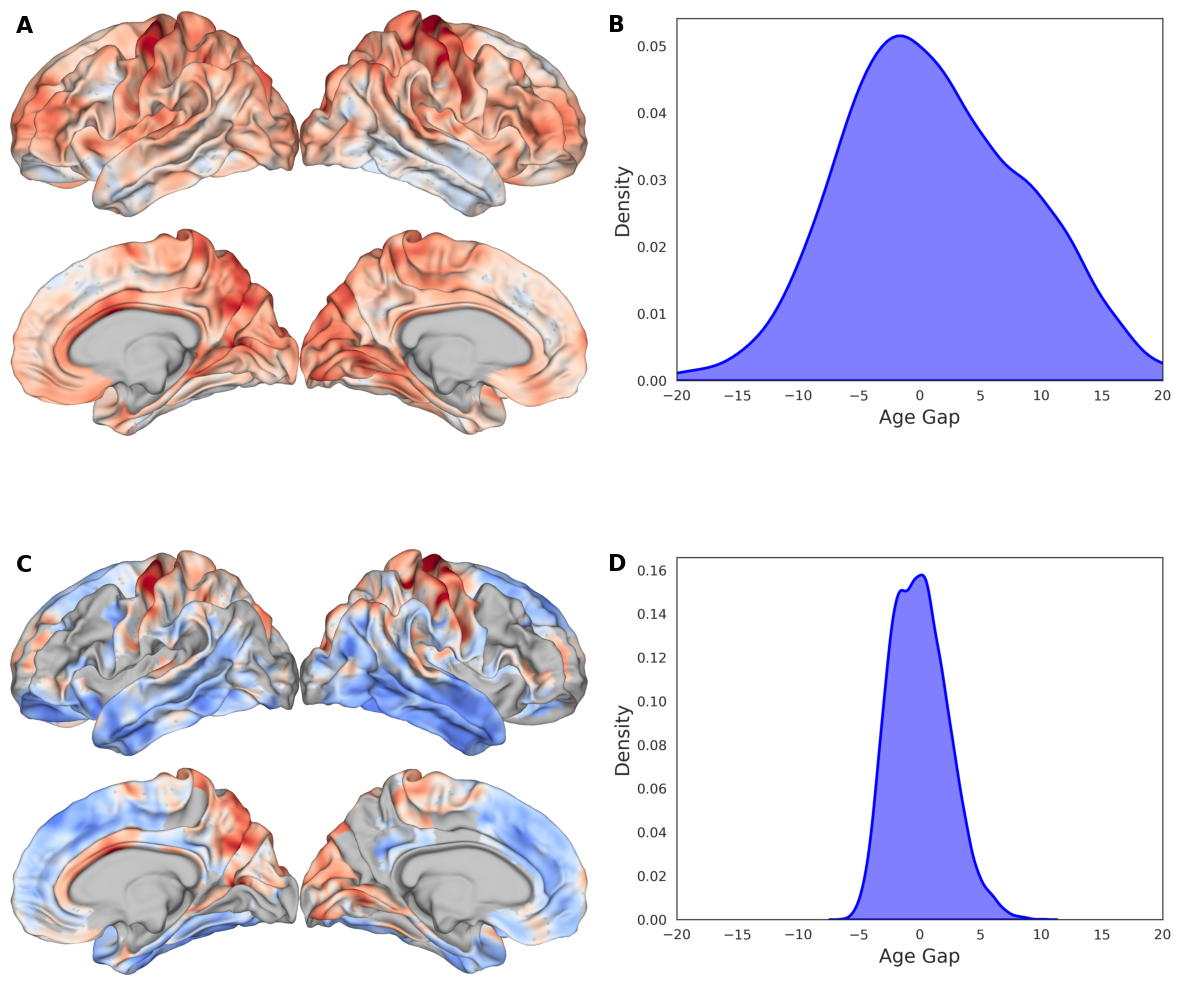

In [5]:
# Load in the 5cv files
fold_output_path = '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/fold_values/'
chr_ages = torch.load(f'{fold_output_path}all_chr_ages.pt').cpu().numpy()
age_gaps = torch.load(f'{fold_output_path}all_age_gaps.pt').cpu().numpy()
pred_per_vertex = torch.load(f'{fold_output_path}all_pred_per_vertex.pt').cpu().numpy()

# Run post-processing
cv_post = postprocess(suffix='5cv')
plot_paths, region_stats_df, _, factors = cv_post(chr_ages, age_gaps, pred_per_vertex)
del cv_post

# Save the factors
np.save(f'{output_dir}5cv_factors', factors)

# Plot the generated images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

# Define subplot labels
subplot_labels = ['A', 'B', 'C', 'D']

# Iterate over the images and their corresponding axes
for ax, path, label in zip(axes, plot_paths, subplot_labels):
    img = mpimg.imread(path)
    ax.imshow(img)
    ax.axis('off')  # Turpred*_per_vertexn off axis labels and ticks
    # Add subplot label in top-left corner
    ax.text(0.01, 0.99, label, transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left', color='black')

plt.tight_layout()  # Adjust layout to prevent overlap

print('\nTop 10 largest errors:'); print(region_stats_df.head(10)); print('\n')
region_stats_df.to_csv(f'{output_dir}5cv_errors.csv', index=True)

=== Train the full model ===

In [6]:
# Train the model
trained_model = run_model(X_train, y_train, None, None, criterion='mae',
                        batch_size=batch_size, batch_load=batch_load, n_epochs=n_train_epochs, lr=lr, 
                        print_every=print_every, ico_levels=[6, 5, 4], first=first, intra_w=intra_w, 
                        global_w=global_w, weight_decay=weight_decay, feature_scale=1, dropout_levels=dropout_levels)

# Save the trained model
torch.save(trained_model.state_dict(), f'{output_dir}trained_weights.pth')


        === Model/Training Parameters ===
        Batch size        : 128
        Batch load        : 128
        Epochs            : 50
        Learning rate     : 0.01
        L2 regularization : 0
        Intra loss weight : 0.5
        Global loss weight: 1
        Feature scale     : 1
        Dropout levels    : [0, 0, 0.5, 0.5, 0]
        


Epoch: 25, MAE: 7.600
Epoch: 50, MAE: 7.319


=== Train the model on non-repeating subjects ===

In [3]:
# Train the model
trained_model = run_model(X_5cv, y_5cv, None, None, criterion='mae',
                        batch_size=batch_size, batch_load=batch_load, n_epochs=n_train_epochs, lr=lr, 
                        print_every=print_every, ico_levels=[6, 5, 4], first=first, intra_w=intra_w, 
                        global_w=global_w, weight_decay=weight_decay, feature_scale=1, dropout_levels=dropout_levels)

# Save the trained model
torch.save(trained_model.state_dict(), f'{output_dir}no_repeats_weights.pth')


        === Model/Training Parameters ===
        Batch size        : 128
        Batch load        : 128
        Epochs            : 50
        Learning rate     : 0.01
        L2 regularization : 0
        Intra loss weight : 0.5
        Global loss weight: 1
        Feature scale     : 1
        Dropout levels    : [0, 0, 0.5, 0.5, 0]
        
Epoch: 25, MAE: 7.454
Epoch: 50, MAE: 7.206
